# Постановка задачи

Задача состоит из следующих шагов:

1.	Поиск и выбор набора данных для построения моделей машинного обучения. На основе выбранного набора данных студент должен построить модели машинного обучения для решения или задачи классификации, или задачи регрессии.
2.	Проведение разведочного анализа данных. Построение графиков, необходимых для понимания структуры данных. Анализ и заполнение пропусков в данных.
3.	Выбор признаков, подходящих для построения моделей. Кодирование категориальных признаков Масштабирование данных. Формирование вспомогательных признаков, улучшающих качество моделей.
4.	Проведение корреляционного анализа данных. Формирование промежуточных выводов о возможности построения моделей машинного обучения. В зависимости от набора данных, порядок выполнения пунктов 2, 3, 4 может быть изменен.
5.	Выбор метрик для последующей оценки качества моделей. Необходимо выбрать не менее двух метрик и обосновать выбор.
6.	Выбор наиболее подходящих моделей для решения задачи классификации или регрессии. Необходимо использовать не менее трех моделей, хотя бы одна из которых должна быть ансамблевой.
7.	Формирование обучающей и тестовой выборок на основе исходного набора данных.
8.	Построение базового решения (baseline) для выбранных моделей без подбора гиперпараметров. Производится обучение моделей на основе обучающей выборки и оценка качества моделей на основе тестовой выборки.
9.	Подбор гиперпараметров для выбранных моделей. Рекомендуется подбирать не более 1-2 гиперпараметров. Рекомендуется использовать методы кросс-валидации. В зависимости от используемой библиотеки можно применять функцию GridSearchCV, использовать перебор параметров в цикле, или использовать другие методы.
10.	Повторение пункта 8 для найденных оптимальных значений гиперпараметров. Сравнение качества полученных моделей с качеством baseline-моделей.
11.	Формирование выводов о качестве построенных моделей на основе выбранных метрик.








# Ход выполнения домашнего задания

## Выбор датасета

Исходными данными в домашнем задании является датасет погоды в Сегеде, который собирался в 2006-2016 годах. 

Дата, получаемая каждый час:

* Время (time)
* Описание (summary)
* Вид осадков (precipType)
* Температура (temperature)
* Температура по ощущению (apparentTemperature)
* Влажность (humidity)
* Скорость ветра (windSpeed)
* Направление ветра (windBearing)
* Видимость (visibility)
* Давление (pressure)





In [0]:
import warnings
warnings.filterwarnings('ignore')

In [0]:
from google.colab import drive, files
drive.mount('/content/drive')

In [0]:
from google.colab import files
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
os.listdir()
data = pd.read_csv('drive/My Drive/Files/weatherHistory.csv',
                   sep=",", encoding="iso-8859-1", parse_dates=True)

## Разведочный анализ и предварительная обработка данных

In [4]:
data.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


Имеющаяся дата имеет не самый удобный способ представления, переведём в формат datetime. Заодно вытянем числовые данные времени для дальнейшего анализа.

In [0]:
data['date'] = pd.to_datetime(data['Formatted Date'], 
                             format='%Y-%m-%d %H:%M:%S', utc=True)
data['hour'] = data['date'].dt.hour
data['day'] = data['date'].dt.day
data['month'] = data['date'].dt.month

In [6]:
data['Loud Cover'].value_counts()

0.0    96453
Name: Loud Cover, dtype: int64

Теперь можем избавиться от предыдущего формата даты. Поле "Loud Cover" не несёт информации, поэтому его также удаляем.

In [0]:
data = data.drop(['Loud Cover', 'Formatted Date'], axis=1)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 14 columns):
Summary                     96453 non-null object
Precip Type                 95936 non-null object
Temperature (C)             96453 non-null float64
Apparent Temperature (C)    96453 non-null float64
Humidity                    96453 non-null float64
Wind Speed (km/h)           96453 non-null float64
Wind Bearing (degrees)      96453 non-null float64
Visibility (km)             96453 non-null float64
Pressure (millibars)        96453 non-null float64
Daily Summary               96453 non-null object
date                        96453 non-null datetime64[ns, UTC]
hour                        96453 non-null int64
day                         96453 non-null int64
month                       96453 non-null int64
dtypes: datetime64[ns, UTC](1), float64(7), int64(3), object(3)
memory usage: 10.3+ MB


Заметим, что у Precip Type есть чуть больше одного значения. В остальном датасет не имеет пробелов, а значит заполнять пропущенные данные или удалять пустые записи не придётся.

Рассмотрим графики температуры.

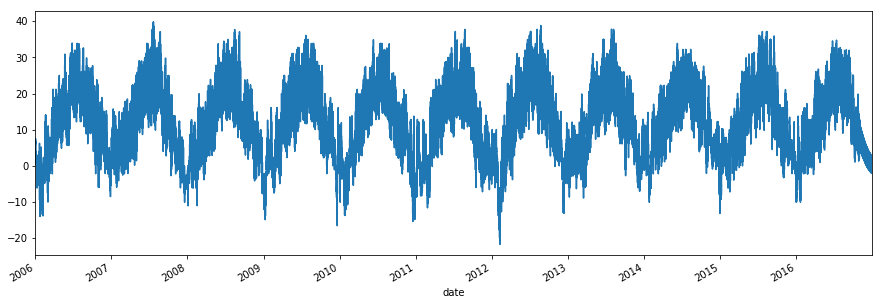

In [9]:
data.set_index('date')['Temperature (C)'].plot(figsize=(15, 5))

На графике температуры видны изменения каждый сезон. Рассмотрим подробнее один из "витков" температуры (возьмём последние 150 дней).

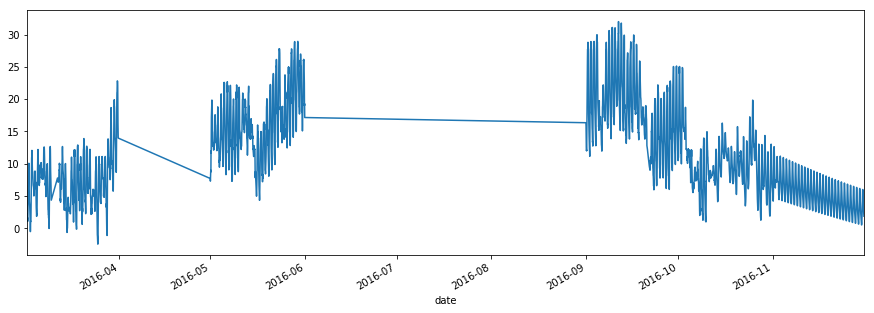

In [10]:
data.set_index('date')['Temperature (C)'].tail(150*24).plot(figsize=(15, 5))

Видно, что замерения иногда происходили неравномерно.

Посмотрим также гистограммы для Precip Type и Summary.

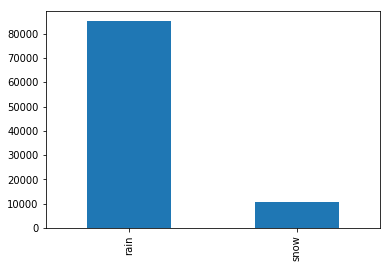

In [11]:
data['Precip Type'].value_counts().plot(kind='bar')

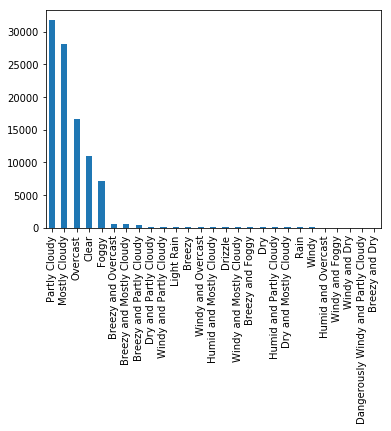

In [12]:
data['Summary'].value_counts().plot(kind='bar')

In [13]:
print("Количество уникальных значений у Summary: {}"
      .format(data['Summary'].value_counts().count()))

Количество уникальных значений у Summary: 27


Summary подойдёт для того, чтобы искать дополнительные зависимости, так как имеет достаточное число классов. Precip Type же не настолько будет информативным.

Посмотрим на значение давления

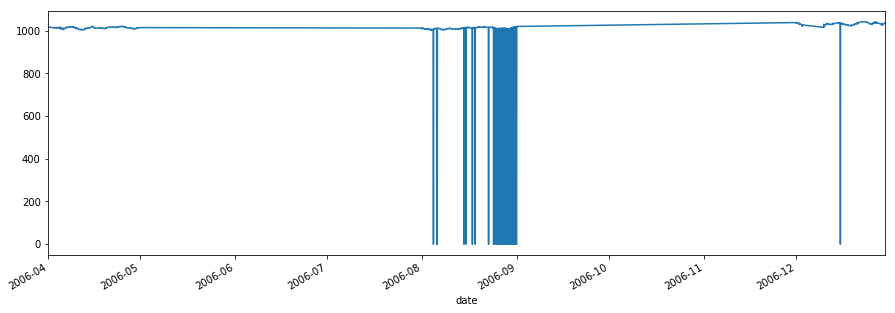

In [71]:
data.set_index('date')['Pressure (millibars)'].head(2000).plot(figsize=(15, 5))

Заметим, что пробелы в середине графика сильно мешают масштабированию данных, поэтому для начала заменим все пустые значения средним

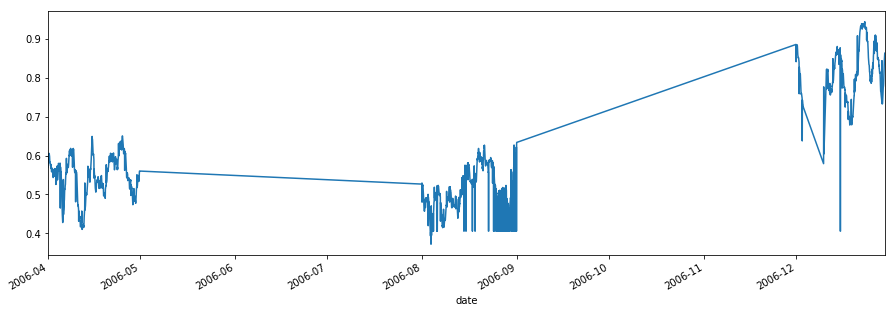

In [15]:
from sklearn.preprocessing import minmax_scale
mean_pressure = data['Pressure (millibars)'].mean()
data.loc[data['Pressure (millibars)'] < 100, 'Pressure (millibars)'] = mean_pressure
data['Pressure'] = minmax_scale(data['Pressure (millibars)'],
                                feature_range=(0, 1), axis=0)
data = data.drop(['Pressure (millibars)'], axis=1)
data.set_index('date')['Pressure'].head(2000).plot(figsize=(15, 5))

Проверим остальные параметры

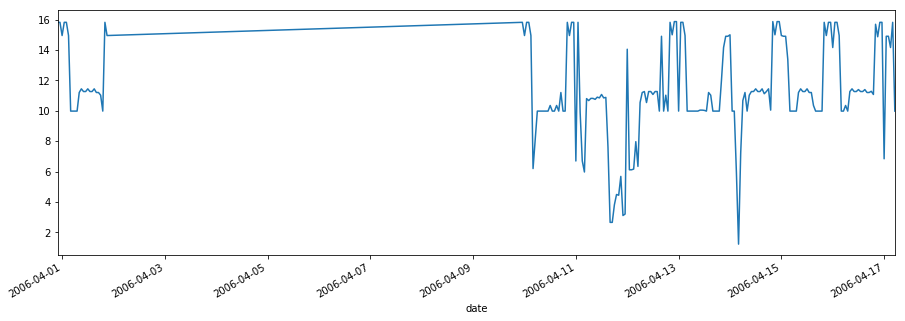

In [16]:
data.set_index('date')['Visibility (km)'].head(200).plot(figsize=(15, 5))

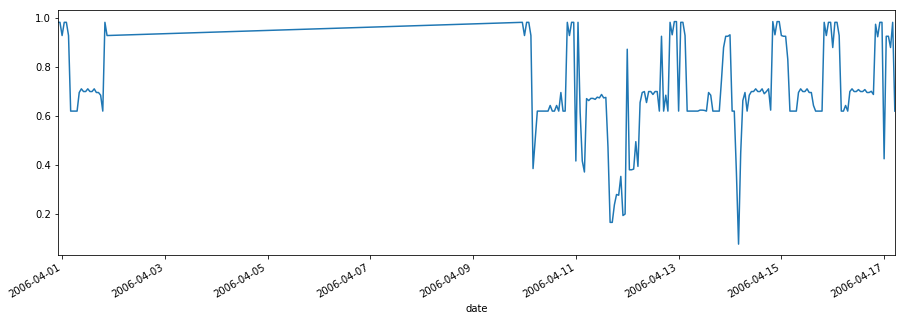

In [17]:
data['Visibility'] = minmax_scale(data['Visibility (km)'],
                                  feature_range=(0, 1), axis=0)
data = data.drop(['Visibility (km)'], axis=1)
data.set_index('date')['Visibility'].head(200).plot(figsize=(15, 5))

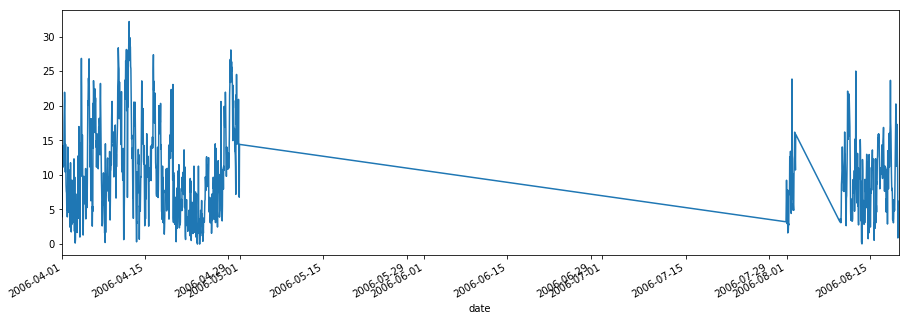

In [18]:
data.set_index('date')['Wind Speed (km/h)'].head(1000).plot(figsize=(15, 5))

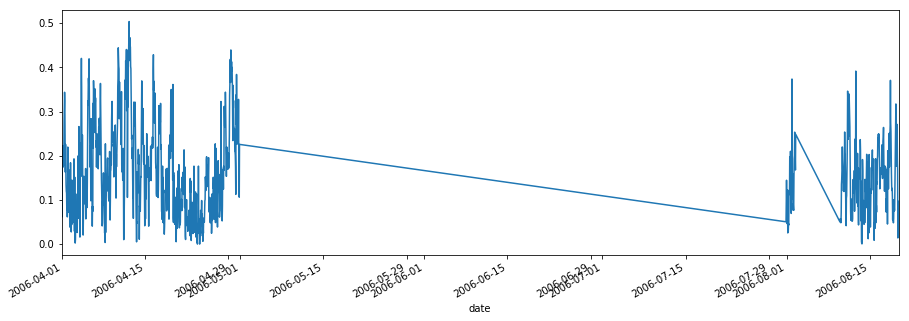

In [19]:
data['Wind_Speed'] = minmax_scale(data['Wind Speed (km/h)'],
                                  feature_range=(0, 1), axis=0)
data = data.drop(['Wind Speed (km/h)'], axis=1)
data.set_index('date')['Wind_Speed'].head(1000).plot(figsize=(15, 5))

Найдём корреляцию между всеми признаками

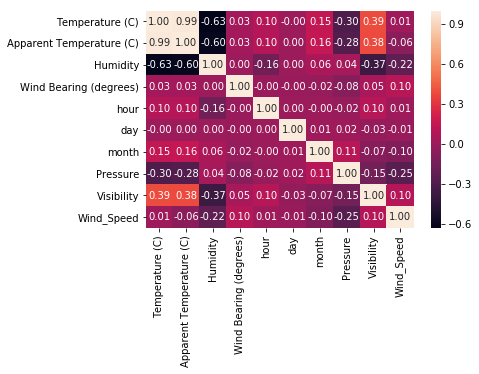

In [20]:
sns.heatmap(data.corr(method='pearson'), annot=True, fmt='.2f')

Заметим следующее:
- Угол и скорость ветра слабо коррелирует с остальными показателями, от него необходимо избавиться;
- Температура и относительная температура сильно коррелируют, так что избавляемся от относительной температуры;
- Номер дня также плохо коррелирует, её тоже отбрасываем.

In [0]:
data = data.drop(['Apparent Temperature (C)', 
                  'Wind Bearing (degrees)', 
                  'Wind_Speed', 'day', 'date'], axis=1)

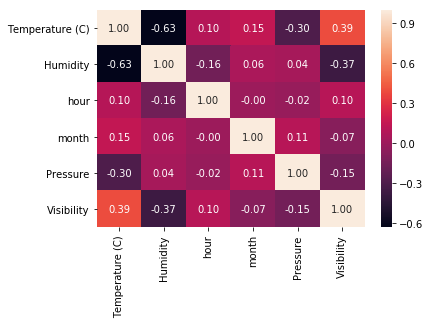

In [22]:
sns.heatmap(data.corr(method='pearson'), annot=True, fmt='.2f')

Будем обучать выявление температуры погоды по описанию погоды, влажности, давлению и видимости, а также час дня и месяц, когда было сделано измерение.


Для использования описания погоды используем one-hot encoder (через get_dummies).

In [0]:
summary_ohe = pd.get_dummies(data['Summary'], prefix='summary', 
                             drop_first=True)
data = pd.concat([data, summary_ohe],axis=1)
data = data.drop(['Summary', 'Daily Summary', 'Precip Type'], axis=1)

## Выбор метрик

Для оценки качества моделей будем использовать следующие метрики:
- Средняя абсолютная ошибка - по ней легко судить о средней оценке ошибки;
- Медиана абсолютной ошибки - другая средняя оценка ошибки, для дополнительной оценки средней абсолютной;
- Объяснимая вариация - вариация изучаемого признака,  зависящая  от  значений признака, положенного  в основу.

In [0]:
from sklearn.metrics import explained_variance_score, \
mean_absolute_error, median_absolute_error

##Выбор моделей

В качестве простой модели используем линейную модель стохастического градиентного спуска, у которого будем менять функцию потерь ($loss$) и скорость обучения ($learning rate$)

In [0]:
from sklearn.linear_model import SGDRegressor

В качестве более сложной модели используем дерево решений, у которого изначально поставим $max depth = 3$.

In [0]:
from sklearn.tree import DecisionTreeRegressor

Из ансамблевых моделей воспользуемся случайным лесом с исходными $n estimators = 10$ и $max depth = 3$.

In [0]:
from sklearn.ensemble import RandomForestRegressor

## Разделение выборки на обучающую и тестовую



In [0]:
from sklearn.model_selection import train_test_split
temperature = data['Temperature (C)']
input_data = data.drop(['Temperature (C)'], axis=1)
data_X_train, data_X_test, data_y_train, data_y_test = train_test_split(
    input_data, temperature, test_size=0.2, random_state=1)

## Базовое решение (baseline)

Для начала предварительно подготовим класс Regressor, который будет собирать необходимые параметры для обучения:

In [0]:
template_header = "Модель {}"
template = "Значение по метрике {}: {:.2f}"

In [0]:
class Regressor():
  def __init__(self, method, metrics, x_train, y_train, x_test, y_test):
    self._method = method
    self.x_train = x_train
    self.y_train = y_train
    self.x_test = x_test
    self.y_test = y_test
    self._metrics = metrics
    self.target_1 = []
    
   
  def training(self):
    self._method.fit(self.x_train, self.y_train)
    self.target_1 = self._method.predict(self.x_test)
    
  def result(self):
    print(template_header.format(self._method))
    for metric in self._metrics:
      print(template.format(metric.__name__, 
                            metric(self.y_test, self.target_1)))
    

In [0]:
choosed_metrics = [explained_variance_score, 
                   mean_absolute_error, 
                   median_absolute_error]
choosed_models = [SGDRegressor(), 
                  DecisionTreeRegressor(max_depth=3), 
                  RandomForestRegressor(n_estimators=10, max_depth=3)]

Обучим выбранные модели и проверим выбранными метриками.

In [62]:
for model in choosed_models:
  regressor = Regressor(model, choosed_metrics, data_X_train, 
                        data_y_train, data_X_test, data_y_test)
  regressor.training()
  regressor.result()

Модель SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.01, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='squared_loss', max_iter=None,
       n_iter=None, n_iter_no_change=5, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, tol=None, validation_fraction=0.1,
       verbose=0, warm_start=False)
Значение по метрике explained_variance_score: 0.55
Значение по метрике mean_absolute_error: 5.50
Значение по метрике median_absolute_error: 4.95
Модель DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')
Значение по метрике explained_variance_score: 0.71
Значение по метрике mean_absolute_error: 4.14
Значение по метрике median_absolute_error: 3.49
Модель

## Подбор гиперпараметра K с использованием GridSearchCV и кросс-валидации

In [0]:
from sklearn.model_selection import ShuffleSplit
choosed_cv = ShuffleSplit(n_splits=5, test_size=0.25)

tuned_parameters_1 = [{'loss': ['squared_loss', 'huber', 'epsilon_insensitive', 
                         'squared_epsilon_insensitive'], 
                        'learning_rate':['constant', 'optimal', 'invscaling']}]
n_range = np.array(range(2,11,1))
tuned_parameters_2 = [{'max_depth': n_range}]
n_range2 = np.array(range(5, 45, 5))
tuned_parameters_3 = [{'n_estimators': n_range2, 'max_depth': n_range}]

In [53]:
from sklearn.model_selection import GridSearchCV

rg_sgd_gs = GridSearchCV(SGDRegressor(), tuned_parameters_1, 
                         cv=choosed_cv, scoring='explained_variance')
rg_sgd_gs.fit(data_X_train, data_y_train)
rg_sgd_gs.best_params_

{'learning_rate': 'invscaling', 'loss': 'squared_loss'}

In [54]:
rg_dtr_gs = GridSearchCV(DecisionTreeRegressor(), tuned_parameters_2, 
                         cv=choosed_cv, scoring='explained_variance')
rg_dtr_gs.fit(data_X_train, data_y_train)
rg_dtr_gs.best_params_

{'max_depth': 10}

In [55]:
rg_rfr_gs = GridSearchCV(RandomForestRegressor(), tuned_parameters_3, 
                         cv=choosed_cv, scoring='explained_variance')
rg_rfr_gs.fit(data_X_train, data_y_train)
rg_rfr_gs.best_params_

{'max_depth': 10, 'n_estimators': 35}

## Сравнение модели с произвольным и лучшим параметром K

Обучим модели на исходных гиперпараметрах и оптимизированных гиперпараметрах.

In [0]:
choosed_and_optimized_models = [SGDRegressor(),
                                SGDRegressor(learning_rate='invscaling',
                                            loss='squared_loss'),
                                DecisionTreeRegressor(max_depth=3),
                                DecisionTreeRegressor(max_depth=10),
                                RandomForestRegressor(n_estimators=10, 
                                                      max_depth=3),
                                RandomForestRegressor(n_estimators=35, 
                                                      max_depth=10)
                               ]

In [67]:
for model in choosed_and_optimized_models:
  regressor = Regressor(model, choosed_metrics, data_X_train, 
                        data_y_train, data_X_test, data_y_test)
  regressor.training()
  regressor.result()
  print('-'*50)

Модель SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.01, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='squared_loss', max_iter=None,
       n_iter=None, n_iter_no_change=5, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, tol=None, validation_fraction=0.1,
       verbose=0, warm_start=False)
Значение по метрике explained_variance_score: 0.55
Значение по метрике mean_absolute_error: 5.35
Значение по метрике median_absolute_error: 4.79
--------------------------------------------------
Модель SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.01, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='squared_loss', max_iter=None,
       n_iter=None, n_iter_no_change=5, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, tol=None, validation_fraction=0.1,
       verbose=0, warm_start=False)
Значение по метрике explained_

# Выводы

По полученным моделям и значениям можно сделать следующие выводы:

* Регрессор градиентного спуска имел наилучшую конфигурацию при стандартных настройках;
* Регрессор показал себя хуже всего в обучении (что неудивительно, так как нету уверенности, что признаки можно линейно связать);
* Для DecisionTreeRegressor и RandomForestRegressor критично задавать оптимальные гиперпараметры, это улучшает точность на порядок;
* Наилучшим образом себя показала модель на RandomForestRegressor благодаря ансамблевому методу. Она объясняет 88% всей вариации признака температуры, что является хорошим показателем.



# Литература

1. Weather in Szeged 2006-2016: https://www.kaggle.com/budincsevity/szeged-weather
2. Model evaluation: quantifying the quality of predictions: https://scikit-learn.org/stable/modules/model_evaluation.html
3. Model selection: choosing estimators and their parameters: https://scikit-learn.org/stable/tutorial/statistical_inference/model_selection.html
4. SGDRegressor: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html
5. DecisionTreeRegressor: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html
6. RandomForestRegressor: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

